# Polylines are just data, part one: Hershey fonts

By [Allison Parrish](http://www.decontextualize.com/)

This notebook shows how to render Hershey fonts with [vsketch](https://github.com/abey79/vsketch) and [Bezmerizing](https://github.com/aparrish/bezmerizing/). I'm going to use this [JSON version of the Hershey fonts](https://github.com/techninja/hersheytextjs), included in this repository as [hersheytext.json](hersheytext.json).

## Hershey fonts

### Getting path data for a character

First, we'll load the JSON:

In [1]:
import json

In [2]:
all_data = json.load(open("./hersheytext.json"))

The JSON file consists of a dictionary whose keys are individual Hershey fonts. The character data for these fonts is stored as the value for the key `chars` in a nested dictionary. Here's a list of all available fonts:

In [3]:
all_data.keys()

dict_keys(['astrology', 'cursive', 'cyrillic', 'futural', 'futuram', 'gothiceng', 'gothicger', 'gothicita', 'greek', 'japanese', 'markers', 'mathlow', 'mathupp', 'meteorology', 'music', 'scriptc', 'scripts', 'symbolic', 'timesg', 'timesi', 'timesib', 'timesr', 'timesrb'])

The cell below grabs the sans-serif 1-stroke Hershey font:

In [4]:
futural = all_data['futural']['chars']

The resulting value is a list that has path data for each letter. To find the index for a letter, take its ASCII value and subtract 33:

In [5]:
def idx(ch):
    return ord(ch) - 33

In [6]:
futural[idx('g')]

{'d': 'M15,8 L15,24 14,27 13,28 11,29 8,29 6,28 M15,11 L13,9 11,8 8,8 6,9 4,11 3,14 3,16 4,19 6,21 8,22 11,22 13,21 15,19',
 'o': 10}

This returns *yet another dictionary*; the path data for the character is the value for key `d`. The function below combines all of this together, giving you the path data for the character in the font that you specify:

In [7]:
def dch(font, ch):
    if ch == ' ':
        return 'M8,0'
    else:
        return font[idx(ch)]['d']
print(dch(futural, 'a'))
print(dch(futural, ' '))

M15,8 L15,22 M15,11 L13,9 11,8 8,8 6,9 4,11 3,14 3,16 4,19 6,21 8,22 11,22 13,21 15,19
M8,0


### Paths to polylines

The path data is stored as [SVG path commands](https://developer.mozilla.org/en-US/docs/Web/SVG/Tutorial/Paths). Only two commands are used: `M` (move to a coordinate) and `L` (draw a line from the current coordinate to the given coordinate, moving the cursor to that coordinate). The following function parses the command string into a list of polylines, which we can then draw with vsketch.

> Note that this is *not* a general function for parsing SVG paths—it only works for the subset of commands that happen to be used in this Hershey font JSON file. The [svg.path package](https://github.com/regebro/svg.path) has an actual SVG path parser.

In [8]:
import vsketch
from bezmerizing import Polyline

Note that we *can't* represent these characters simply as polylines, because they often consist of more than one stroke. Instead, I'm going to represent them as *lists* of polylines—so, in actually, a list of lists of lists:

In [9]:
import numpy as np
def to_plist(font, ch):
    plines = []
    current_plist = []
    mode = ''
    for t in dch(font, ch).split():
        if t[0] in ('M', 'L'):
            mode = t[0]
            t = t[1:]
        coords = [int(x) for x in t.split(',')]
        if mode == 'M':
            if len(current_plist) > 0:
                plines.append(current_plist)
                current_plist = []
        current_plist.append(coords)
    plines.append(current_plist)
    return plines

Now the `to_plist()` function takes a Hershey font object (retrieved from the JSON) and the character you want to convert to a list of polylines. This returns a list of polylines:

In [10]:
x_plist = to_plist(futural, "x")
x_plist

[[[3, 8], [14, 22]], [[14, 8], [3, 22]]]

Take a moment to consider this data structure! This represents the letter `x`, which consists of two strokes. Each stroke is a polyline (though in this case, a polyline with only one segment—so, two points in total), and each point in the polyline is a list with two items (the X and Y coordinates). Finally, the letter is represented as a sequence of these strokes. So: a list of lists of lists.

Let's draw this real quick with vsketch.

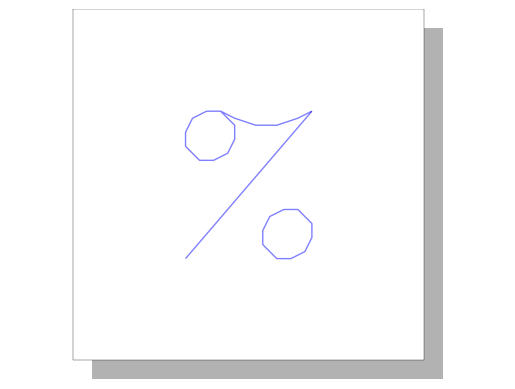

In [11]:
vsk = vsketch.Vsketch()
vsk.size("50mm", "50mm")
vsk.scale("1mm")
for pline in to_plist(futural, "%"): # replace with whatever character you want
    vsk.polygon(pline)
vsk.display()

Very cool.

### Transforming lists of polylines

You can transform a list of polylines in the same way that we discussed transforming polylines in [the "Polylines are just numbers" notebook](polylines-are-just-numbers.ipynb), but you need to apply the transformation to *each polyline* in the list of polylines. Here's how to shear a letter `R`, for example:

In [12]:
sheared_plist = []
angle = np.pi * -0.25
# iterate over every stroke
for pline in to_plist(futural, 'R'):
    sheared_stroke = []
    # every coordinate in this stroke
    for coord in pline:
        sheared_stroke.append([coord[0]+angle*coord[1], coord[1]])
    # append to the transformed list of polylines
    sheared_plist.append(sheared_stroke)

Here's the original and the transformed version superimposed on one another:

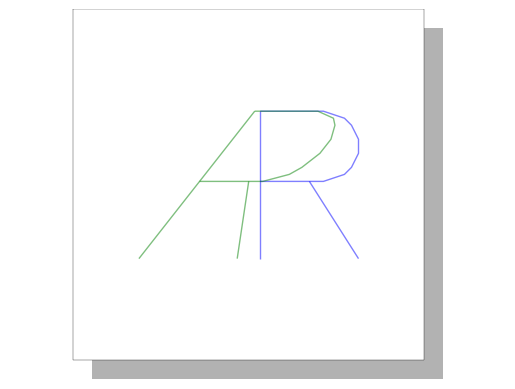

In [13]:
vsk = vsketch.Vsketch()
vsk.size("50mm", "50mm")
vsk.scale("1mm")
vsk.stroke(1)
for pline in to_plist(futural, "R"):
    vsk.polygon(pline)
vsk.stroke(2)
for pline in sheared_plist:
    vsk.polygon(pline)
vsk.display()

### Text layout with Hershey fonts

Laying out text is tricky, as we've discussed extensively in class! The simplest way to lay out a stretch of text in a script derived from the Latin alphabet (written left to right) is like so:

* Keep track of the position of a "cursor"
* Place each glyph from the text in turn at the current position of the cursor. After placing the glyph, advance the cursor by the width of the character you just placed.

The following function lays out a string with the specified Hershey font on a single line, by creating a new polyline list that contains each Hershey character, offset by the width of the character that came before. The `kern` parameter controls how much spacing is inserted between each character.

In [14]:
def str_to_plist(font, s, kern=1):
    current_x = 0
    all_plines = []
    for ch in s:
        max_x = 0
        for pline in to_plist(font, ch):
            # translate to the current position of cursor
            translated = [[x+current_x, y] for x, y in pline]
            x_extent = max([c[0] for c in pline])
            if x_extent > max_x:
                max_x = x_extent
            all_plines.append(translated)
        current_x += max_x + kern
    return all_plines

The result is, again, a list of lists of lists: each stroke is represented by a list of 2d coordinates.

In [15]:
str_plist = str_to_plist(futural, "zit tix")
str_plist

[[[14, 8], [3, 22]],
 [[3, 8], [14, 8]],
 [[3, 22], [14, 22]],
 [[18, 1], [19, 2], [20, 1], [19, 0], [18, 1]],
 [[19, 8], [19, 22]],
 [[26, 1], [26, 18], [27, 21], [29, 22], [31, 22]],
 [[23, 8], [30, 8]],
 [[40, 0]],
 [[46, 1], [46, 18], [47, 21], [49, 22], [51, 22]],
 [[43, 8], [50, 8]],
 [[55, 1], [56, 2], [57, 1], [56, 0], [55, 1]],
 [[56, 8], [56, 22]],
 [[61, 8], [72, 22]],
 [[72, 8], [61, 22]]]

To draw these with vsketch, you need to draw each stroke individually:

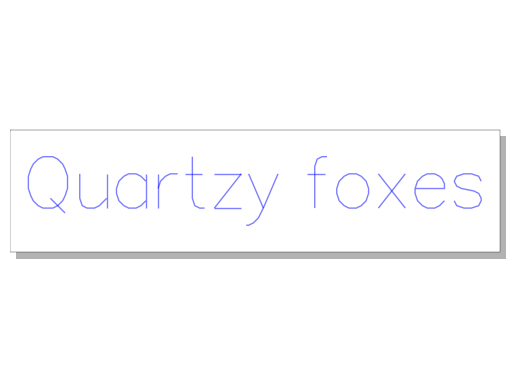

In [16]:
vsk = vsketch.Vsketch()
vsk.size("200mm", "50mm")
vsk.scale("1mm")
for pline in str_to_plist(futural, "Quartzy foxes"):
    vsk.polygon(pline)
vsk.display()

Here's another example, using the `cursive` set, specifying the `kern` parameter to keep the letters connected:

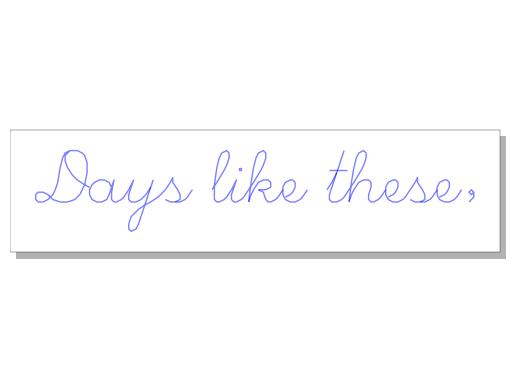

In [17]:
vsk = vsketch.Vsketch()
vsk.size("200mm", "50mm")
vsk.scale("1mm")
for pline in str_to_plist(all_data['cursive']['chars'], "Days like these,", kern=0):
    vsk.polygon(pline)
vsk.display()

The following code incorporates word wrapping to lay out text on multiple lines. It uses the `str_to_plist` method to generate paths for each word, then checks to see if the width of the word would extend past the edge of the box (given the current cursor position). If so, it puts that word on the next line instead.

In [18]:
from itertools import chain
def str_to_plist_wrap(font, s, kern=1, lineheight=32, width=360, height=360):
    current = [0, 0]
    all_plists = []
    for word in s.split():
        wplist = str_to_plist(font, word, kern)
        # flatten the list of strokes to find the biggest X coordinate
        wplist_width = max([c[0] for c in chain(*wplist)])
        if current[0] + wplist_width > width:
            current[1] += lineheight
            current[0] = 0
        if current[1] > height - lineheight:
            break
        wplist_translated = []
        # translate all polylines
        for pline in wplist:
            wplist_translated.append(
                [[x+current[0], y+current[1]] for x, y in pline])
        # add these translated strokes to the big list
        all_plists.extend(wplist_translated)
        current[0] += wplist_width + 8 # width of space
    return all_plists

Here's a quote from Johanna Drucker's *The Visible Word*, laid out with a Hershey font:

In [19]:
src = '''\
The threat to linguistic authority made by the manipulation
of the words on the page was that it returned the written
language to the specific place, instance, conditions of
production: it became a highly marked text. The unmarked
text... appeared, as it were, to "speak itself."'''

And here's what it looks like all typeset. Note that the parameters `width` and `height` of the `str_to_plist_wrap` function are based on the dimensions of the Hershey letters themselves, as specified in the source data. You may need to futz around a bit to get these dimensions to match up with the size that you want to draw the text on the canvas.

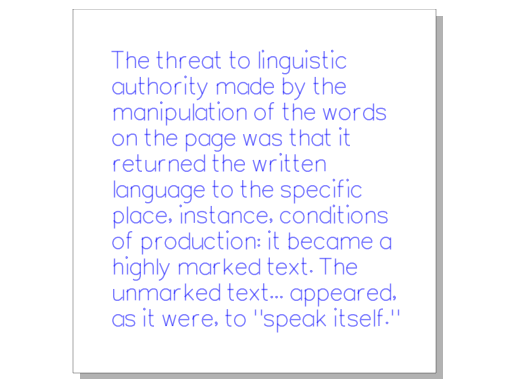

In [20]:
vsk = vsketch.Vsketch()
vsk.size("150mm", "150mm")
vsk.scale("1mm")
vsk.scale(0.333)
for pline in str_to_plist_wrap(futural, src):
    vsk.polygon(pline)
vsk.display()

## Make asemic glyphs from Hershey font data

Let's play around with this data a little bit by making "cutups" with the Hershey characters. In the following cell, I make a big list of all of the polylines in any of the characters in the font. For polylines longer than a particular length, I split the polylines in two and add the halves separately.

In [21]:
chars = 'abcdefghijklmnopqrstuvwxyz'
chars += chars.upper()
chars += '01234567890!@#$%^&*()'
all_strokes = []
for item in chars:
    plist = str_to_plist(futural, item)
    for stroke in plist:
        if len(stroke) >= 6:
            # first half of polyline
            all_strokes.append(stroke[:int(len(stroke)/2)])
            # second half of polyline
            all_strokes.append(stroke[int(len(stroke)/2):])
        else:
            all_strokes.append(stroke)

Here's a method of making a new glyph simply by picking three polylines at random and superimposing them:

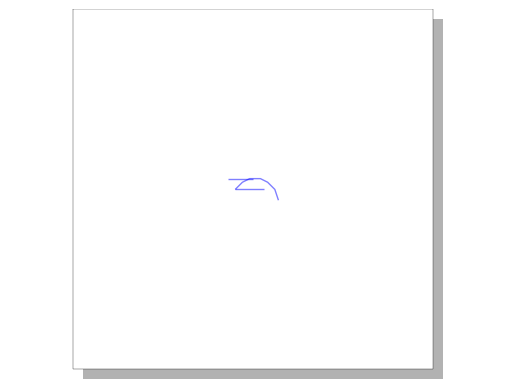

In [23]:
import random
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
for stroke in random.sample(all_strokes, 3):
    vsk.polygon(stroke)
vsk.display()

Or you can do the following: Take two strokes at random, connect them together (by squishing the coordinates from both polylines into a single polyline). The code below shows an entire line of glyphs composed in this fashion:

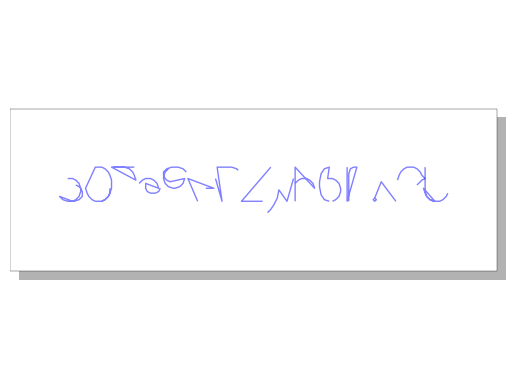

In [24]:
import random
vsk = vsketch.Vsketch()
vsk.size("150mm", "50mm")
vsk.scale("1mm")
for i in range(15):
    strokes = random.sample(all_strokes, 2)
    smooshed = list(chain(*strokes))
    with vsk.pushMatrix():
        vsk.translate(-50 + i * 8, 0)
        vsk.scale(0.5)
        vsk.polygon(smooshed)
vsk.display()

## Bonus example: Modifying coordinates with simplex noise

[Simplex noise](https://en.wikipedia.org/wiki/Simplex_noise) is a generalized and improved version of [Perlin noise](https://en.wikipedia.org/wiki/Perlin_noise). The Python [opensimplex](https://github.com/lmas/opensimplex) library provides an efficient and user-friendly interface for producing Simplex noise. We're going to use it to do weird stuff to the coordinates in our Hershey text. First, install the library:

In [25]:
import sys
!{sys.executable} -m pip install opensimplex


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


Then import it:

In [26]:
import opensimplex

The `opensimplex` module has a couple of methods that we'll use. The `.noise2()` method takes two parameters (i.e., a 2d coordinate) and returns a random number for that coordinate:

In [27]:
opensimplex.noise2(10, 20)

np.float64(-0.5274028646454091)

The random values range from -1 to 1. Simplex noise has the property that random numbers generated from nearby points will also be similar:

In [28]:
opensimplex.noise2(10.01, 20.01)

np.float64(-0.5419635028277792)

The `.noise3d()` method does the same thing, but with 3d coordinates instead of 2d coordinates:

In [29]:
opensimplex.noise3(1, 5, 9)

np.float64(-0.31715210355987017)

As a quick example, let's draw a 2d grid of ellipses whose width is determined by the simplex noise at the ellipse's coordinate:

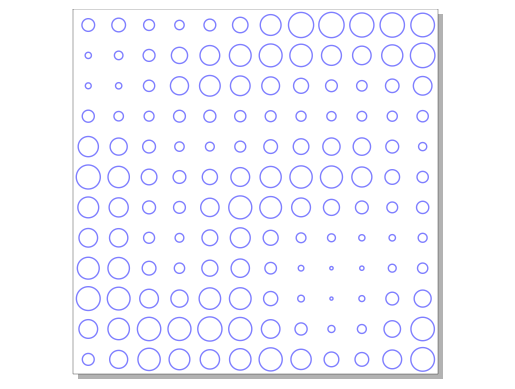

In [30]:
width = 200
height = 200
grid_size = 12
cell_size = width/grid_size
noise_step = 0.02
vsk = vsketch.Vsketch()
vsk.size(f"{width}mm", f"{height}mm")
vsk.scale("1mm")
for i in range(grid_size):
    for j in range(grid_size):
        x = (i * cell_size) + cell_size * 0.5
        y = (j * cell_size) + cell_size * 0.5
        val = opensimplex.noise2(x*noise_step, y*noise_step)
        val_scaled = (val + 1) * 0.5
        vsk.circle(x, y, val_scaled * cell_size)
vsk.display()

Try adjusting the value of `noise_step`. If the value is too large, then you end up sampling from the noise at points that are too distant from each other, so the resulting values are very different from each other. At around 0.01 or 0.02, you see that the colors of adjacent circles are random, but still similar to those that surround them.

I'll use this same technique to make our Hershey text look "warped" by adding values generated by simplex noise to the `x` and `y` coordinates of each command in the Hershey text path.

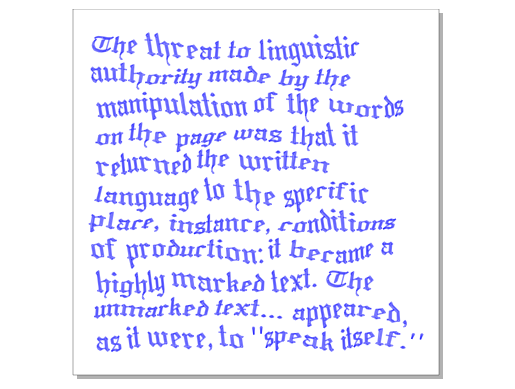

In [31]:
text_plist = str_to_plist_wrap(all_data['gothiceng']['chars'], src, kern=0)
doc_height = 240 # mm
doc_width = 240 # mm
nstep = 0.02 # movement over noise space
namp = 8 # noise multiplier
vsk = vsketch.Vsketch()
vsk.size(f"{doc_height}mm", f"{doc_width}mm")
vsk.scale("1mm")
vsk.scale(0.6)
for pline in text_plist:
    noise_pline = [[x + opensimplex.noise2(x*nstep, y*nstep)*namp,
                    y + opensimplex.noise2(x*nstep, y*nstep)*namp]
                   for x, y in pline]
    vsk.polygon(noise_pline)
vsk.display()